In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [3]:
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")

In [4]:
df = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True) # not using imputer as this doesn't remove too many rows
drop_cols = ["fnlwgt","workclass","native.country", "education"]
df.drop(columns=drop_cols, inplace=True)
df.columns = df.columns.str.replace('.', '_', regex=False).str.lower().str.strip()
categorical_cols = df.select_dtypes(include="object").columns

In [5]:
df['income'] = df['income'].str.strip()
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [7]:
df.head()

,age,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
1,82,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,0
3,54,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,0
4,41,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,0
5,34,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,0
6,38,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,0


In [6]:
X = df.drop("income", axis=1)
y = df["income"]

In [7]:
categorical_cols = categorical_cols.tolist()
categorical_cols.remove('income')

In [8]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [13]:
type(X)

pandas.core.frame.DataFrame

In [14]:
type(y)

pandas.core.series.Series

In [9]:
y = y.values

In [16]:
type(y)

numpy.ndarray

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [20]:
print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)
print(type(X_train))

(21113, 34)
(4524, 34)
(4525, 34)
<class 'pandas.core.frame.DataFrame'>


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_dev = scaler.transform(X_dev.values)
X_test = scaler.transform(X_test.values)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [14]:
from sklearn.metrics import f1_score

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad() # clear prev mini batch gradients
        out = model(xb)
        loss = criterion(out, yb.float())
        loss.backward() # back prop
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for xb, yb in loader:
            out = model(xb)
            loss = criterion(out, yb.float())
            total_loss += loss.item() * xb.size(0)
            preds += (out > 0.5).long().tolist() # threshold 0.5
            targets += yb.tolist()
    f1 = f1_score(targets, preds) # use f1 score
    return total_loss / len(loader.dataset), f1


In [15]:
import torch.nn as nn

class ANN1(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_units, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze()


In [16]:
class ANN2(nn.Module):
    def __init__(self, input_dim, hidden_units1, hidden_units2, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_units1),
            nn.BatchNorm1d(hidden_units1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units1, hidden_units2),
            nn.BatchNorm1d(hidden_units2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_units2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze()


In [17]:
import matplotlib.pyplot as plt

In [39]:


def run_trial(X_train, y_train, X_dev, y_dev,
              model_type=1,
              hidden_units1=64, hidden_units2=32,
              dropout_rate=0.3,
              lr=1e-3,
              betas=(0.9, 0.999),
              epsilon=1e-8,
              weight_decay=1e-4,
              amsgrad=False,
              mini_batch_size=64,
              num_epochs=20,
              verbose=True, plot=True):

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.long))

    dev_ds = TensorDataset(torch.tensor(X_dev, dtype=torch.float32),
                       torch.tensor(y_dev, dtype=torch.long))


    train_loader = DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True)
    dev_loader = DataLoader(dev_ds, batch_size=256)

    input_dim = X_train.shape[1]
    if model_type == 1:
        model = ANN1(input_dim=input_dim, hidden_units=hidden_units1, dropout_rate=dropout_rate)
    elif model_type == 2:
        model = ANN2(input_dim=input_dim, hidden_units1=hidden_units1, hidden_units2=hidden_units2, dropout_rate=dropout_rate)
    else:
        raise ValueError("model_type must be 1 or 2")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, betas=betas, eps=epsilon,
        weight_decay=weight_decay, amsgrad=amsgrad
    )
    criterion = nn.BCELoss()

    train_losses = []
    dev_losses = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        dev_loss, f1 = evaluate(model, dev_loader, criterion)

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)

        if verbose:
            print(f"[Model={model_type}] Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Dev Loss: {dev_loss:.4f} | Dev F1: {f1:.4f}")

    if(plot):
        plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs+1), dev_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss vs Epochs (lr={lr}, batch={mini_batch_size})")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model


[Model=2] Epoch 01 | Train Loss: 0.4175 | Dev Loss: 0.3337 | Dev F1: 0.6926
[Model=2] Epoch 02 | Train Loss: 0.3578 | Dev Loss: 0.3273 | Dev F1: 0.6957
[Model=2] Epoch 03 | Train Loss: 0.3488 | Dev Loss: 0.3205 | Dev F1: 0.7052
[Model=2] Epoch 04 | Train Loss: 0.3468 | Dev Loss: 0.3221 | Dev F1: 0.7115
[Model=2] Epoch 05 | Train Loss: 0.3424 | Dev Loss: 0.3185 | Dev F1: 0.7101
[Model=2] Epoch 06 | Train Loss: 0.3406 | Dev Loss: 0.3183 | Dev F1: 0.6853
[Model=2] Epoch 07 | Train Loss: 0.3369 | Dev Loss: 0.3167 | Dev F1: 0.7054
[Model=2] Epoch 08 | Train Loss: 0.3386 | Dev Loss: 0.3187 | Dev F1: 0.7007
[Model=2] Epoch 09 | Train Loss: 0.3358 | Dev Loss: 0.3175 | Dev F1: 0.6928
[Model=2] Epoch 10 | Train Loss: 0.3311 | Dev Loss: 0.3134 | Dev F1: 0.6948
[Model=2] Epoch 11 | Train Loss: 0.3325 | Dev Loss: 0.3104 | Dev F1: 0.6998
[Model=2] Epoch 12 | Train Loss: 0.3324 | Dev Loss: 0.3131 | Dev F1: 0.7003
[Model=2] Epoch 13 | Train Loss: 0.3307 | Dev Loss: 0.3095 | Dev F1: 0.6932
[Model=2] Ep

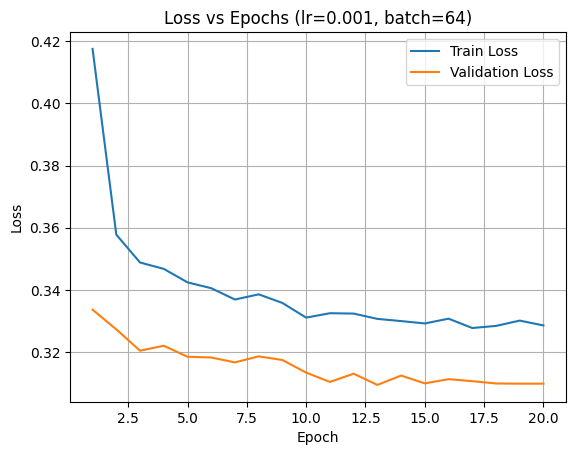

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [40]:
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.3,        

    lr=1e-3,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=64,      
    num_epochs=20,            

    verbose=True,
    plot=True
)


Gap suggests possible overfitting.  Will add more epochs to see if more decrease is possible.
It is not too noisy suggesting mini batch size is probably good enough. It is decreasing pretty sharply at the beginning, is the lr too high?

[Model=2] Epoch 01 | Train Loss: 0.4181 | Dev Loss: 0.3322 | Dev F1: 0.6962
[Model=2] Epoch 02 | Train Loss: 0.3571 | Dev Loss: 0.3224 | Dev F1: 0.7013
[Model=2] Epoch 03 | Train Loss: 0.3485 | Dev Loss: 0.3255 | Dev F1: 0.7033
[Model=2] Epoch 04 | Train Loss: 0.3472 | Dev Loss: 0.3190 | Dev F1: 0.6923
[Model=2] Epoch 05 | Train Loss: 0.3415 | Dev Loss: 0.3192 | Dev F1: 0.6964
[Model=2] Epoch 06 | Train Loss: 0.3419 | Dev Loss: 0.3141 | Dev F1: 0.6943
[Model=2] Epoch 07 | Train Loss: 0.3374 | Dev Loss: 0.3172 | Dev F1: 0.6775
[Model=2] Epoch 08 | Train Loss: 0.3352 | Dev Loss: 0.3174 | Dev F1: 0.6981
[Model=2] Epoch 09 | Train Loss: 0.3346 | Dev Loss: 0.3127 | Dev F1: 0.6994
[Model=2] Epoch 10 | Train Loss: 0.3330 | Dev Loss: 0.3160 | Dev F1: 0.6996
[Model=2] Epoch 11 | Train Loss: 0.3315 | Dev Loss: 0.3160 | Dev F1: 0.6733
[Model=2] Epoch 12 | Train Loss: 0.3320 | Dev Loss: 0.3154 | Dev F1: 0.6822
[Model=2] Epoch 13 | Train Loss: 0.3320 | Dev Loss: 0.3122 | Dev F1: 0.6952
[Model=2] Ep

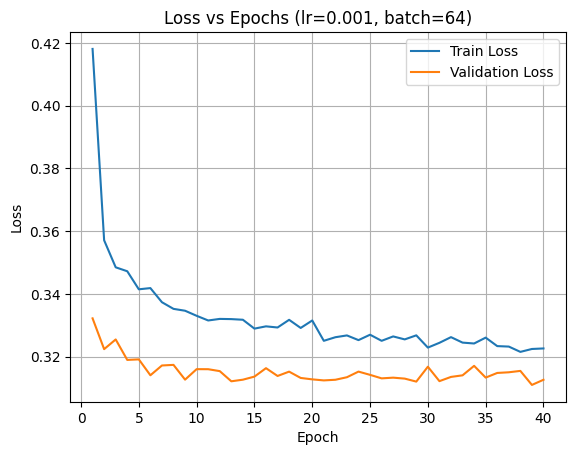

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [41]:
# trying with  more epochs, same set up other than that
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.3,        

    lr=1e-3,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=64,      
    num_epochs=40,            

    verbose=True,
    plot=True
)

Loss gap is decreasing from epoch 20 to 40, but loss it not

[Model=2] Epoch 01 | Train Loss: 0.5280 | Dev Loss: 0.3900 | Dev F1: 0.6836
[Model=2] Epoch 02 | Train Loss: 0.3789 | Dev Loss: 0.3348 | Dev F1: 0.6924
[Model=2] Epoch 03 | Train Loss: 0.3579 | Dev Loss: 0.3267 | Dev F1: 0.6995
[Model=2] Epoch 04 | Train Loss: 0.3521 | Dev Loss: 0.3236 | Dev F1: 0.7004
[Model=2] Epoch 05 | Train Loss: 0.3486 | Dev Loss: 0.3218 | Dev F1: 0.7029
[Model=2] Epoch 06 | Train Loss: 0.3476 | Dev Loss: 0.3170 | Dev F1: 0.7017
[Model=2] Epoch 07 | Train Loss: 0.3443 | Dev Loss: 0.3162 | Dev F1: 0.6915
[Model=2] Epoch 08 | Train Loss: 0.3413 | Dev Loss: 0.3150 | Dev F1: 0.7013
[Model=2] Epoch 09 | Train Loss: 0.3382 | Dev Loss: 0.3166 | Dev F1: 0.7117
[Model=2] Epoch 10 | Train Loss: 0.3387 | Dev Loss: 0.3140 | Dev F1: 0.7038
[Model=2] Epoch 11 | Train Loss: 0.3360 | Dev Loss: 0.3132 | Dev F1: 0.6952
[Model=2] Epoch 12 | Train Loss: 0.3342 | Dev Loss: 0.3131 | Dev F1: 0.7043
[Model=2] Epoch 13 | Train Loss: 0.3359 | Dev Loss: 0.3151 | Dev F1: 0.7086
[Model=2] Ep

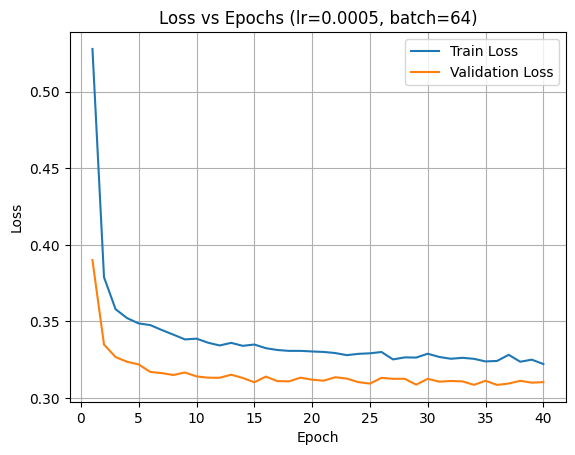

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [42]:
# decreasing learning rate
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.3,        

    lr=5e-4,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=64,      
    num_epochs=40,            

    verbose=True,
    plot=True
)

[Model=2] Epoch 01 | Train Loss: 0.3909 | Dev Loss: 0.3249 | Dev F1: 0.6922
[Model=2] Epoch 02 | Train Loss: 0.3353 | Dev Loss: 0.3200 | Dev F1: 0.6901
[Model=2] Epoch 03 | Train Loss: 0.3273 | Dev Loss: 0.3151 | Dev F1: 0.6918
[Model=2] Epoch 04 | Train Loss: 0.3253 | Dev Loss: 0.3146 | Dev F1: 0.6863
[Model=2] Epoch 05 | Train Loss: 0.3210 | Dev Loss: 0.3134 | Dev F1: 0.6834
[Model=2] Epoch 06 | Train Loss: 0.3194 | Dev Loss: 0.3101 | Dev F1: 0.7051
[Model=2] Epoch 07 | Train Loss: 0.3172 | Dev Loss: 0.3119 | Dev F1: 0.7028
[Model=2] Epoch 08 | Train Loss: 0.3178 | Dev Loss: 0.3103 | Dev F1: 0.7010
[Model=2] Epoch 09 | Train Loss: 0.3158 | Dev Loss: 0.3094 | Dev F1: 0.7036
[Model=2] Epoch 10 | Train Loss: 0.3142 | Dev Loss: 0.3117 | Dev F1: 0.6905
[Model=2] Epoch 11 | Train Loss: 0.3125 | Dev Loss: 0.3119 | Dev F1: 0.6807
[Model=2] Epoch 12 | Train Loss: 0.3119 | Dev Loss: 0.3118 | Dev F1: 0.6947
[Model=2] Epoch 13 | Train Loss: 0.3107 | Dev Loss: 0.3086 | Dev F1: 0.7013
[Model=2] Ep

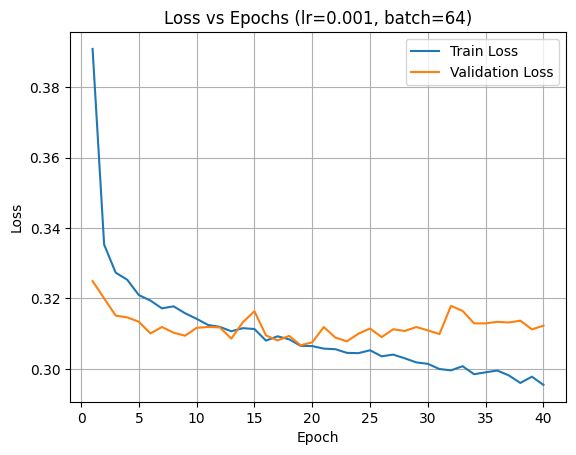

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [43]:
# loss has hit plateu learning rate too slow? also realized i forgot to test the base model! 
# need to test base model without regularization. keeping batch norm though.

# test wiht no weight decay adn zero dropout
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0,        

    lr=1e-3,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=0,        

    mini_batch_size=64,      
    num_epochs=40,            

    verbose=True,
    plot=True
)

We notice overfitting  in base model (its does have batch norm though)

[Model=2] Epoch 01 | Train Loss: 0.3625 | Dev Loss: 0.3236 | Dev F1: 0.6928
[Model=2] Epoch 02 | Train Loss: 0.3340 | Dev Loss: 0.3188 | Dev F1: 0.6684
[Model=2] Epoch 03 | Train Loss: 0.3281 | Dev Loss: 0.3087 | Dev F1: 0.6878
[Model=2] Epoch 04 | Train Loss: 0.3236 | Dev Loss: 0.3152 | Dev F1: 0.6918
[Model=2] Epoch 05 | Train Loss: 0.3231 | Dev Loss: 0.3120 | Dev F1: 0.6967
[Model=2] Epoch 06 | Train Loss: 0.3186 | Dev Loss: 0.3121 | Dev F1: 0.6979
[Model=2] Epoch 07 | Train Loss: 0.3179 | Dev Loss: 0.3082 | Dev F1: 0.7050
[Model=2] Epoch 08 | Train Loss: 0.3178 | Dev Loss: 0.3125 | Dev F1: 0.6981
[Model=2] Epoch 09 | Train Loss: 0.3146 | Dev Loss: 0.3115 | Dev F1: 0.7051
[Model=2] Epoch 10 | Train Loss: 0.3140 | Dev Loss: 0.3085 | Dev F1: 0.7041
[Model=2] Epoch 11 | Train Loss: 0.3139 | Dev Loss: 0.3101 | Dev F1: 0.6937
[Model=2] Epoch 12 | Train Loss: 0.3119 | Dev Loss: 0.3097 | Dev F1: 0.6825
[Model=2] Epoch 13 | Train Loss: 0.3112 | Dev Loss: 0.3087 | Dev F1: 0.7019
[Model=2] Ep

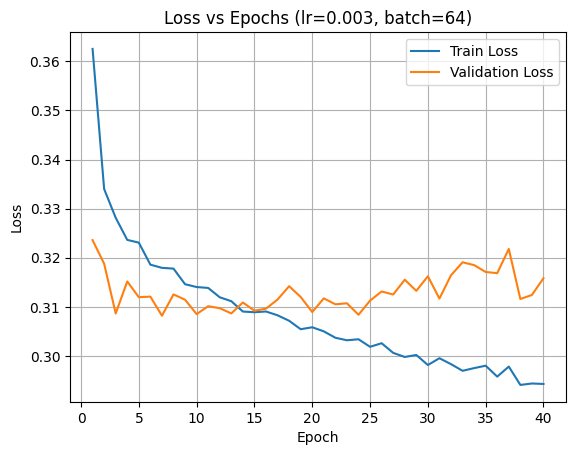

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [44]:
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0,        

    lr=3e-3,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=0,        

    mini_batch_size=64,      
    num_epochs=40,            

    verbose=True,
    plot=True
)

Trying a very low learning rate

[Model=2] Epoch 01 | Train Loss: 0.5854 | Dev Loss: 0.5684 | Dev F1: 0.0891
[Model=2] Epoch 02 | Train Loss: 0.5635 | Dev Loss: 0.5542 | Dev F1: 0.1810
[Model=2] Epoch 03 | Train Loss: 0.5449 | Dev Loss: 0.5333 | Dev F1: 0.3029
[Model=2] Epoch 04 | Train Loss: 0.5287 | Dev Loss: 0.5149 | Dev F1: 0.3340
[Model=2] Epoch 05 | Train Loss: 0.5134 | Dev Loss: 0.5019 | Dev F1: 0.3790
[Model=2] Epoch 06 | Train Loss: 0.5015 | Dev Loss: 0.4927 | Dev F1: 0.3948
[Model=2] Epoch 07 | Train Loss: 0.4884 | Dev Loss: 0.4758 | Dev F1: 0.4085
[Model=2] Epoch 08 | Train Loss: 0.4776 | Dev Loss: 0.4723 | Dev F1: 0.5103
[Model=2] Epoch 09 | Train Loss: 0.4688 | Dev Loss: 0.4560 | Dev F1: 0.6183
[Model=2] Epoch 10 | Train Loss: 0.4599 | Dev Loss: 0.4485 | Dev F1: 0.6052
[Model=2] Epoch 11 | Train Loss: 0.4527 | Dev Loss: 0.4388 | Dev F1: 0.6256
[Model=2] Epoch 12 | Train Loss: 0.4474 | Dev Loss: 0.4355 | Dev F1: 0.6424
[Model=2] Epoch 13 | Train Loss: 0.4400 | Dev Loss: 0.4259 | Dev F1: 0.6432
[Model=2] Ep

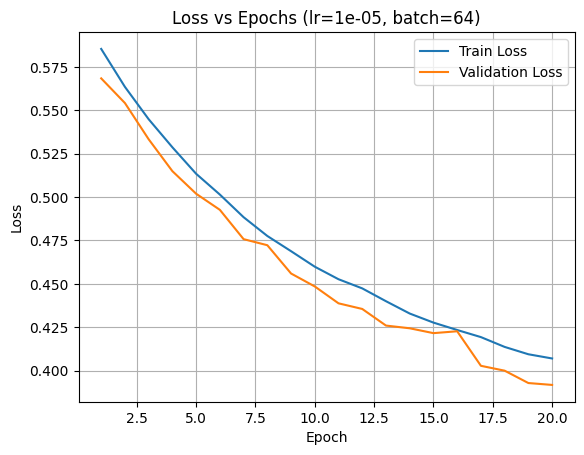

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [46]:
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.2,        

    lr=1e-5,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=64,      
    num_epochs=20,            

    verbose=True,
    plot=True
)

[Model=2] Epoch 01 | Train Loss: 0.6706 | Dev Loss: 0.5595 | Dev F1: 0.6276
[Model=2] Epoch 02 | Train Loss: 0.5204 | Dev Loss: 0.4684 | Dev F1: 0.6804
[Model=2] Epoch 03 | Train Loss: 0.4485 | Dev Loss: 0.4126 | Dev F1: 0.6835
[Model=2] Epoch 04 | Train Loss: 0.4112 | Dev Loss: 0.3811 | Dev F1: 0.6778
[Model=2] Epoch 05 | Train Loss: 0.3912 | Dev Loss: 0.3675 | Dev F1: 0.6829
[Model=2] Epoch 06 | Train Loss: 0.3758 | Dev Loss: 0.3527 | Dev F1: 0.6877
[Model=2] Epoch 07 | Train Loss: 0.3675 | Dev Loss: 0.3435 | Dev F1: 0.6925
[Model=2] Epoch 08 | Train Loss: 0.3626 | Dev Loss: 0.3353 | Dev F1: 0.6984
[Model=2] Epoch 09 | Train Loss: 0.3591 | Dev Loss: 0.3352 | Dev F1: 0.6954
[Model=2] Epoch 10 | Train Loss: 0.3557 | Dev Loss: 0.3331 | Dev F1: 0.6707
[Model=2] Epoch 11 | Train Loss: 0.3515 | Dev Loss: 0.3273 | Dev F1: 0.6894
[Model=2] Epoch 12 | Train Loss: 0.3508 | Dev Loss: 0.3259 | Dev F1: 0.7000
[Model=2] Epoch 13 | Train Loss: 0.3494 | Dev Loss: 0.3253 | Dev F1: 0.6882
[Model=2] Ep

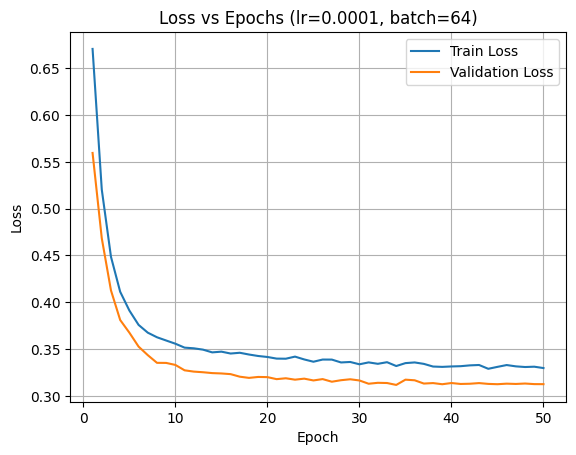

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [49]:
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.2,        

    lr=1e-4,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=64,      
    num_epochs=50,            

    verbose=True,
    plot=True
)

[Model=2] Epoch 01 | Train Loss: 0.5425 | Dev Loss: 0.4386 | Dev F1: 0.6679
[Model=2] Epoch 02 | Train Loss: 0.4185 | Dev Loss: 0.3746 | Dev F1: 0.6841
[Model=2] Epoch 03 | Train Loss: 0.3825 | Dev Loss: 0.3551 | Dev F1: 0.6891
[Model=2] Epoch 04 | Train Loss: 0.3728 | Dev Loss: 0.3459 | Dev F1: 0.6747
[Model=2] Epoch 05 | Train Loss: 0.3661 | Dev Loss: 0.3348 | Dev F1: 0.6923
[Model=2] Epoch 06 | Train Loss: 0.3591 | Dev Loss: 0.3298 | Dev F1: 0.6945
[Model=2] Epoch 07 | Train Loss: 0.3572 | Dev Loss: 0.3262 | Dev F1: 0.6966
[Model=2] Epoch 08 | Train Loss: 0.3559 | Dev Loss: 0.3250 | Dev F1: 0.6886
[Model=2] Epoch 09 | Train Loss: 0.3529 | Dev Loss: 0.3294 | Dev F1: 0.6798
[Model=2] Epoch 10 | Train Loss: 0.3497 | Dev Loss: 0.3229 | Dev F1: 0.6775
[Model=2] Epoch 11 | Train Loss: 0.3517 | Dev Loss: 0.3253 | Dev F1: 0.6749
[Model=2] Epoch 12 | Train Loss: 0.3485 | Dev Loss: 0.3237 | Dev F1: 0.6966
[Model=2] Epoch 13 | Train Loss: 0.3504 | Dev Loss: 0.3227 | Dev F1: 0.7062
[Model=2] Ep

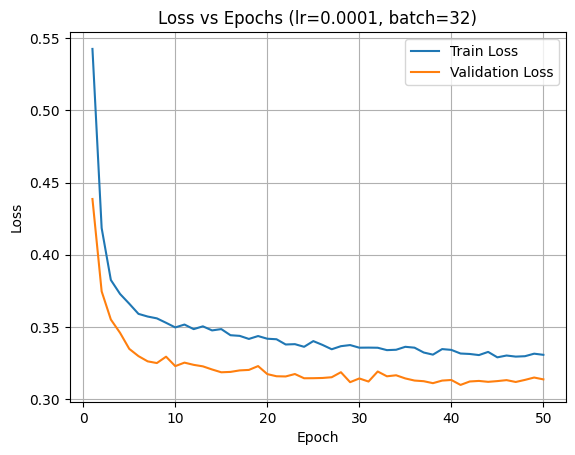

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [50]:
# decreasing mini batch size, should see more noise
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.2,        

    lr=1e-4,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=32,      
    num_epochs=50,            

    verbose=True,
    plot=True
)

Trying Model 1

[Model=1] Epoch 01 | Train Loss: 0.3846 | Dev Loss: 0.3248 | Dev F1: 0.6809
[Model=1] Epoch 02 | Train Loss: 0.3355 | Dev Loss: 0.3145 | Dev F1: 0.6798
[Model=1] Epoch 03 | Train Loss: 0.3285 | Dev Loss: 0.3137 | Dev F1: 0.6801
[Model=1] Epoch 04 | Train Loss: 0.3256 | Dev Loss: 0.3133 | Dev F1: 0.6850
[Model=1] Epoch 05 | Train Loss: 0.3233 | Dev Loss: 0.3072 | Dev F1: 0.7038
[Model=1] Epoch 06 | Train Loss: 0.3222 | Dev Loss: 0.3094 | Dev F1: 0.7104
[Model=1] Epoch 07 | Train Loss: 0.3189 | Dev Loss: 0.3132 | Dev F1: 0.7071
[Model=1] Epoch 08 | Train Loss: 0.3196 | Dev Loss: 0.3121 | Dev F1: 0.6984
[Model=1] Epoch 09 | Train Loss: 0.3160 | Dev Loss: 0.3078 | Dev F1: 0.6925
[Model=1] Epoch 10 | Train Loss: 0.3183 | Dev Loss: 0.3093 | Dev F1: 0.7053
[Model=1] Epoch 11 | Train Loss: 0.3167 | Dev Loss: 0.3092 | Dev F1: 0.6978
[Model=1] Epoch 12 | Train Loss: 0.3162 | Dev Loss: 0.3117 | Dev F1: 0.6954
[Model=1] Epoch 13 | Train Loss: 0.3156 | Dev Loss: 0.3083 | Dev F1: 0.7094
[Model=1] Ep

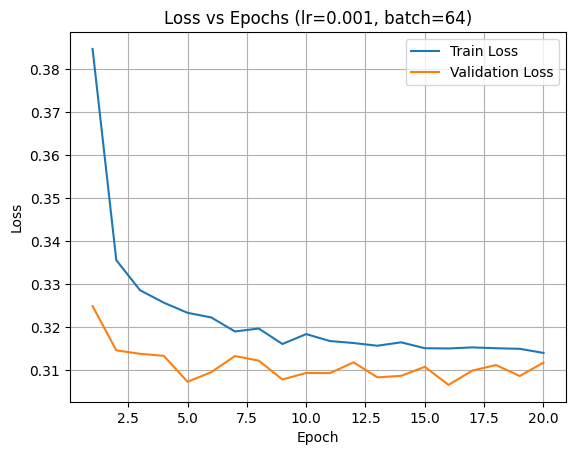

ANN1(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [51]:

run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=1,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0,        

    lr=1e-3,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=0,        

    mini_batch_size=64,      
    num_epochs=20,            

    verbose=True,
    plot=True
)

[Model=1] Epoch 01 | Train Loss: 0.5763 | Dev Loss: 0.4941 | Dev F1: 0.4828
[Model=1] Epoch 02 | Train Loss: 0.4465 | Dev Loss: 0.4095 | Dev F1: 0.6169
[Model=1] Epoch 03 | Train Loss: 0.3963 | Dev Loss: 0.3713 | Dev F1: 0.6494
[Model=1] Epoch 04 | Train Loss: 0.3725 | Dev Loss: 0.3520 | Dev F1: 0.6670
[Model=1] Epoch 05 | Train Loss: 0.3601 | Dev Loss: 0.3413 | Dev F1: 0.6667
[Model=1] Epoch 06 | Train Loss: 0.3531 | Dev Loss: 0.3331 | Dev F1: 0.6725
[Model=1] Epoch 07 | Train Loss: 0.3483 | Dev Loss: 0.3297 | Dev F1: 0.6700
[Model=1] Epoch 08 | Train Loss: 0.3435 | Dev Loss: 0.3244 | Dev F1: 0.6824
[Model=1] Epoch 09 | Train Loss: 0.3406 | Dev Loss: 0.3225 | Dev F1: 0.6852
[Model=1] Epoch 10 | Train Loss: 0.3376 | Dev Loss: 0.3195 | Dev F1: 0.6807
[Model=1] Epoch 11 | Train Loss: 0.3357 | Dev Loss: 0.3170 | Dev F1: 0.6894
[Model=1] Epoch 12 | Train Loss: 0.3333 | Dev Loss: 0.3171 | Dev F1: 0.6917
[Model=1] Epoch 13 | Train Loss: 0.3331 | Dev Loss: 0.3154 | Dev F1: 0.7003
[Model=1] Ep

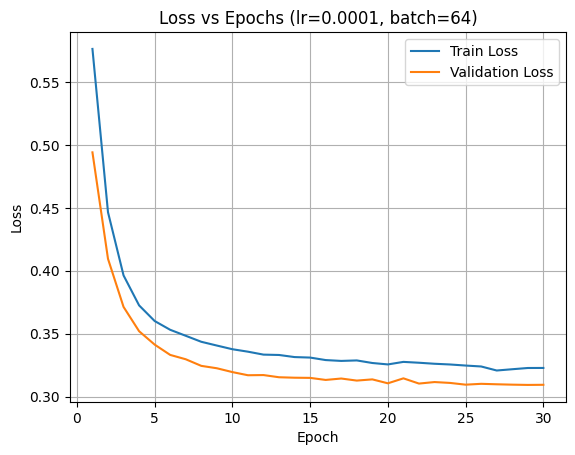

ANN1(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [55]:

run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=1,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0,        

    lr=1e-4,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=0,        

    mini_batch_size=64,      
    num_epochs=30,            

    verbose=True,
    plot=True
)

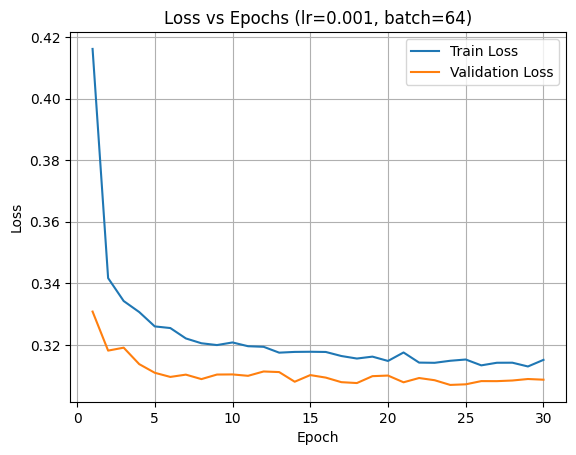

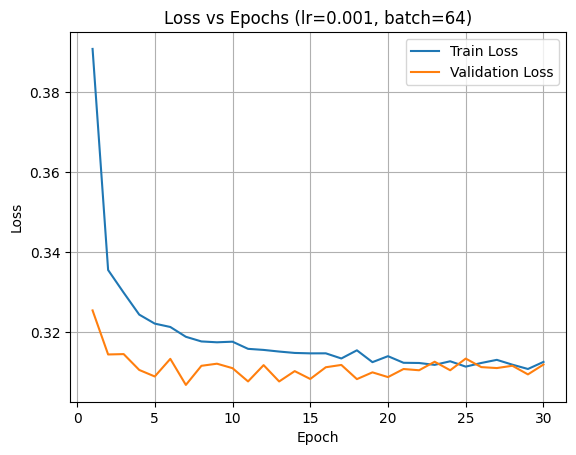

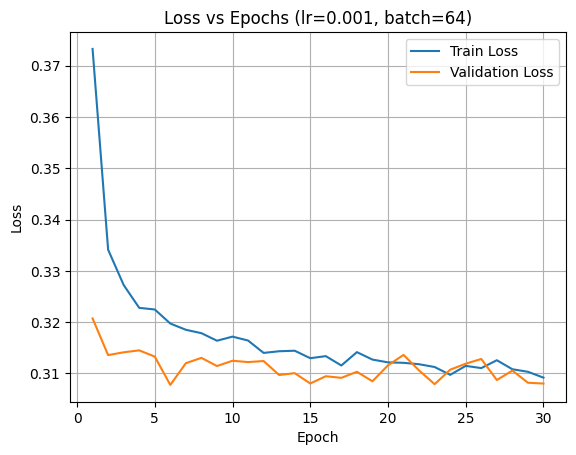

In [56]:
for hidden_units1 in [32,64,128]:
    run_trial(
        X_train=X_train,        
        y_train=y_train,          
        X_dev=X_dev,              
        y_dev=y_dev,              
    
        model_type=1,             
        hidden_units1=hidden_units1,         
        hidden_units2=32,         
        dropout_rate=0,  # keeping dropout zero because is not showing signs of overfitting      
    
        lr=1e-3,                  
        betas=(0.9, 0.999),      
        epsilon=1e-8,            
        weight_decay=1e-4,        
    
        mini_batch_size=64,      
        num_epochs=30,            
    
        verbose=False,
        plot=True
    )

[Model=1] Epoch 01 | Train Loss: 0.5671 | Dev Loss: 0.4418 | Dev F1: 0.5859
[Model=1] Epoch 02 | Train Loss: 0.4136 | Dev Loss: 0.3739 | Dev F1: 0.6380
[Model=1] Epoch 03 | Train Loss: 0.3748 | Dev Loss: 0.3513 | Dev F1: 0.6608
[Model=1] Epoch 04 | Train Loss: 0.3606 | Dev Loss: 0.3404 | Dev F1: 0.6743
[Model=1] Epoch 05 | Train Loss: 0.3517 | Dev Loss: 0.3331 | Dev F1: 0.6790
[Model=1] Epoch 06 | Train Loss: 0.3451 | Dev Loss: 0.3283 | Dev F1: 0.6788
[Model=1] Epoch 07 | Train Loss: 0.3414 | Dev Loss: 0.3222 | Dev F1: 0.6790
[Model=1] Epoch 08 | Train Loss: 0.3386 | Dev Loss: 0.3210 | Dev F1: 0.6894
[Model=1] Epoch 09 | Train Loss: 0.3372 | Dev Loss: 0.3204 | Dev F1: 0.6826
[Model=1] Epoch 10 | Train Loss: 0.3356 | Dev Loss: 0.3172 | Dev F1: 0.6930
[Model=1] Epoch 11 | Train Loss: 0.3325 | Dev Loss: 0.3153 | Dev F1: 0.6801
[Model=1] Epoch 12 | Train Loss: 0.3317 | Dev Loss: 0.3157 | Dev F1: 0.6935
[Model=1] Epoch 13 | Train Loss: 0.3301 | Dev Loss: 0.3143 | Dev F1: 0.6830
[Model=1] Ep

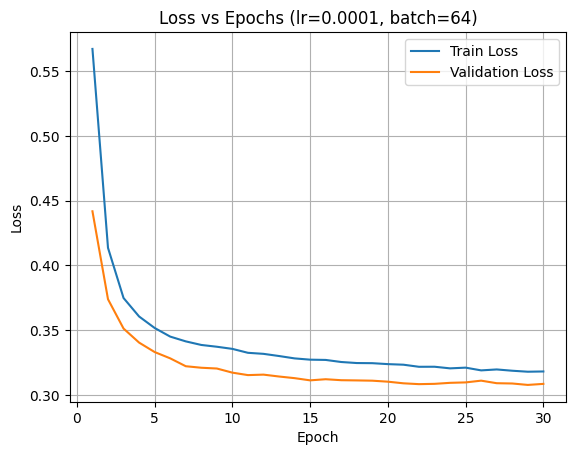

ANN1(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [57]:
# using hidden unit size 128
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=1,             
    hidden_units1=128,         
    hidden_units2=32,         
    dropout_rate=0,        

    lr=1e-4,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=1e-4,        

    mini_batch_size=64,      
    num_epochs=30,            

    verbose=True,
    plot=True
)

[Model=2] Epoch 01 | Train Loss: 0.3911 | Dev Loss: 0.3248 | Dev F1: 0.6991
[Model=2] Epoch 02 | Train Loss: 0.3470 | Dev Loss: 0.3161 | Dev F1: 0.7007
[Model=2] Epoch 03 | Train Loss: 0.3365 | Dev Loss: 0.3175 | Dev F1: 0.6827
[Model=2] Epoch 04 | Train Loss: 0.3334 | Dev Loss: 0.3132 | Dev F1: 0.6919
[Model=2] Epoch 05 | Train Loss: 0.3322 | Dev Loss: 0.3105 | Dev F1: 0.7010
[Model=2] Epoch 06 | Train Loss: 0.3300 | Dev Loss: 0.3131 | Dev F1: 0.7071
[Model=2] Epoch 07 | Train Loss: 0.3269 | Dev Loss: 0.3114 | Dev F1: 0.6767
[Model=2] Epoch 08 | Train Loss: 0.3262 | Dev Loss: 0.3168 | Dev F1: 0.7011
[Model=2] Epoch 09 | Train Loss: 0.3273 | Dev Loss: 0.3132 | Dev F1: 0.6998
[Model=2] Epoch 10 | Train Loss: 0.3246 | Dev Loss: 0.3105 | Dev F1: 0.7021
[Model=2] Epoch 11 | Train Loss: 0.3242 | Dev Loss: 0.3116 | Dev F1: 0.6960
[Model=2] Epoch 12 | Train Loss: 0.3242 | Dev Loss: 0.3140 | Dev F1: 0.6948
[Model=2] Epoch 13 | Train Loss: 0.3234 | Dev Loss: 0.3100 | Dev F1: 0.6994
[Model=2] Ep

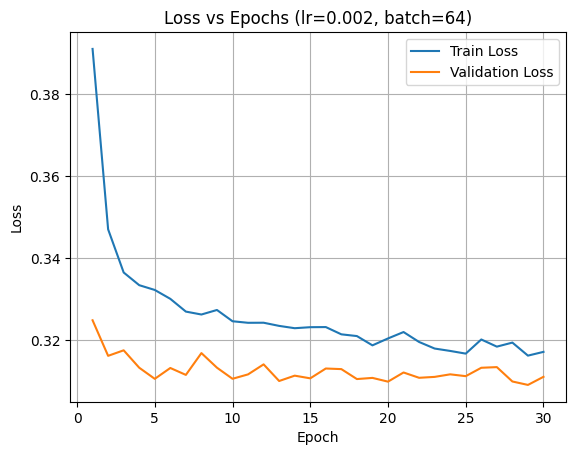

ANN2(
  (net): Sequential(
    (0): Linear(in_features=34, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [59]:
run_trial(
    X_train=X_train,        
    y_train=y_train,          
    X_dev=X_dev,              
    y_dev=y_dev,              

    model_type=2,             
    hidden_units1=64,         
    hidden_units2=32,         
    dropout_rate=0.2,        

    lr=2e-3,                  
    betas=(0.9, 0.999),      
    epsilon=1e-8,            
    weight_decay=0,        

    mini_batch_size=64,      
    num_epochs=30,            

    verbose=True,
    plot=True
)

In [64]:
def get_model(model_type, input_dim, hidden1, hidden2, dropout):
    if model_type == 1:
        return ANN1(input_dim, hidden1, dropout)
    else:
        return ANN2(input_dim, hidden1, hidden2, dropout)


In [73]:
import optuna
from optuna.importance import get_param_importances
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # For BCELoss, use float
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)


In [78]:
import optuna
from optuna.exceptions import TrialPruned

def objective(trial):
    model_type = trial.suggest_int('model_type', 1, 2)
    hidden1 = trial.suggest_int('hidden_units1', 32, 128)
    hidden2 = trial.suggest_int('hidden_units2', 16, 64) if model_type == 2 else None
    dropout = trial.suggest_float('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    beta1 = trial.suggest_float('beta1', 0.85, 0.95)
    beta2 = trial.suggest_float('beta2', 0.95, 0.999)
    eps = trial.suggest_float('eps', 1e-10, 1e-6, log=True)

    model = get_model(model_type, input_dim=X_train.shape[1],
                      hidden1=hidden1, hidden2=hidden2,
                      dropout=dropout)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), eps=eps, weight_decay=weight_decay)
    criterion = nn.BCELoss()

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    for epoch in range(5):  # few epochs just for ranking
        train_one_epoch(model, train_loader, optimizer, criterion)

        # Evaluate and report
        val_loss, f1 = evaluate(model, val_loader, criterion)
        trial.report(f1, step=epoch)  # Report intermediate objective

        # Check if trial should be pruned
        if trial.should_prune():
            raise TrialPruned()

    return f1  # Maximize F1 score


In [79]:
study = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)
study.optimize(objective, n_trials=50)


[I 2025-06-10 08:11:15,161] A new study created in memory with name: no-name-41920927-6a1b-4390-9bb3-31333111660f
[I 2025-06-10 08:11:19,260] Trial 0 finished with value: 0.542696629213483 and parameters: {'model_type': 1, 'hidden_units1': 126, 'dropout_rate': 0.4231423588448846, 'lr': 1.4293125849768742e-05, 'weight_decay': 0.00856119466711904, 'beta1': 0.9048247321484412, 'beta2': 0.9971162828276319, 'eps': 3.215218473286617e-08}. Best is trial 0 with value: 0.542696629213483.
[I 2025-06-10 08:11:23,285] Trial 1 finished with value: 0.6848659003831418 and parameters: {'model_type': 1, 'hidden_units1': 113, 'dropout_rate': 0.22057405632450106, 'lr': 0.00021565501604856304, 'weight_decay': 2.410437309633781e-05, 'beta1': 0.901635456768889, 'beta2': 0.997846212489402, 'eps': 4.6212251058662466e-08}. Best is trial 1 with value: 0.6848659003831418.
[I 2025-06-10 08:11:28,478] Trial 2 finished with value: 0.646061814556331 and parameters: {'model_type': 2, 'hidden_units1': 44, 'hidden_unit

In [81]:
importances = get_param_importances(study)

print("\nHyperparameter Importance (based on F1 score):\n")
for param, imp in importances.items():
    print(f"{param:<15}: {imp:.4f}")



Hyperparameter Importance (based on F1 score):

lr             : 0.3476
hidden_units1  : 0.3435
weight_decay   : 0.1902
dropout_rate   : 0.0692
beta2          : 0.0336
beta1          : 0.0131
eps            : 0.0015
model_type     : 0.0013


In [83]:
print(f"Best Score: {study.best_value}")
print(f"Best Params: {study.best_params}")
print(f"Best Trial: {study.best_trial}")
print(f"Best Trial Params: {study.best_trial.params}")

Best Score: 0.7065267001369239
Best Params: {'model_type': 2, 'hidden_units1': 45, 'hidden_units2': 52, 'dropout_rate': 0.4200529870237565, 'lr': 0.0009422027049854098, 'weight_decay': 0.0003610489522618087, 'beta1': 0.896481591949775, 'beta2': 0.992638407914088, 'eps': 7.789148511291706e-09}
Best Trial: FrozenTrial(number=30, state=1, values=[0.7065267001369239], datetime_start=datetime.datetime(2025, 6, 10, 8, 13, 9, 360517), datetime_complete=datetime.datetime(2025, 6, 10, 8, 13, 14, 979681), params={'model_type': 2, 'hidden_units1': 45, 'hidden_units2': 52, 'dropout_rate': 0.4200529870237565, 'lr': 0.0009422027049854098, 'weight_decay': 0.0003610489522618087, 'beta1': 0.896481591949775, 'beta2': 0.992638407914088, 'eps': 7.789148511291706e-09}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.6924428822495606, 1: 0.688132474701012, 2: 0.7023809523809524, 3: 0.7079646017699115, 4: 0.7065267001369239}, distributions={'model_type': IntDistribution(high=2, log=False, low=1, st

In [84]:
import optuna
from optuna.exceptions import TrialPruned

def objective_2(trial):
    model_type = 2  

    hidden1 = trial.suggest_int('hidden_units1', 32, 128, step=8)
    hidden2 = trial.suggest_int('hidden_units2', 16, 64, step=8)
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    weight_decay = 0.0003610489522618087 # best found
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    model = get_model(model_type, input_dim=X_train.shape[1],
                      hidden1=hidden1, hidden2=hidden2,
                      dropout=dropout)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), eps=eps, weight_decay=weight_decay)
    criterion = nn.BCELoss()

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    for epoch in range(5):  # few epochs just for ranking
        train_one_epoch(model, train_loader, optimizer, criterion)

        val_loss, f1 = evaluate(model, val_loader, criterion)
        trial.report(f1, step=epoch)

        if trial.should_prune():
            raise TrialPruned()

    return f1  # maximize F1


In [85]:
import optuna
from optuna.pruners import MedianPruner

study = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=1)
)

study.optimize(objective_2, n_trials=200, show_progress_bar=True)

print("Best F1 Score:", study.best_value)
print("Best Trial Params:")
for key, value in study.best_params.items():
    print(f"{key:<15}: {value:.4f}" if isinstance(value, float) else f"{key:<15}: {value}")


[I 2025-06-10 08:20:24,184] A new study created in memory with name: no-name-375124d8-6766-4876-bc21-663f873dd977


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-10 08:20:29,912] Trial 0 finished with value: 0.690394929302779 and parameters: {'hidden_units1': 56, 'hidden_units2': 40, 'dropout_rate': 0.25700079287002864, 'lr': 0.001272020590563819}. Best is trial 0 with value: 0.690394929302779.
[I 2025-06-10 08:20:35,990] Trial 1 finished with value: 0.6953610712577715 and parameters: {'hidden_units1': 72, 'hidden_units2': 64, 'dropout_rate': 0.2823528811120323, 'lr': 0.0016211007455665973}. Best is trial 1 with value: 0.6953610712577715.
[I 2025-06-10 08:20:42,030] Trial 2 finished with value: 0.6833088595203133 and parameters: {'hidden_units1': 112, 'hidden_units2': 32, 'dropout_rate': 0.1263402479231686, 'lr': 0.006619496717430993}. Best is trial 1 with value: 0.6953610712577715.
[I 2025-06-10 08:20:47,731] Trial 3 finished with value: 0.7056638811513464 and parameters: {'hidden_units1': 80, 'hidden_units2': 32, 'dropout_rate': 0.1463930247717091, 'lr': 0.00030519867943336034}. Best is trial 3 with value: 0.7056638811513464.
[I 20

In [18]:
best_model = ANN2(input_dim=X.shape[1], hidden_units1=128, hidden_units2=32, dropout_rate=0.2009)

In [19]:
optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=0.0058
)

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

Confusion Matrix:
 [[3153  246]
 [ 423  703]]
Accuracy      : 0.8522
Precision     : 0.7408
Recall        : 0.6243
F1 Score      : 0.6776
ROC AUC Score : 0.9098


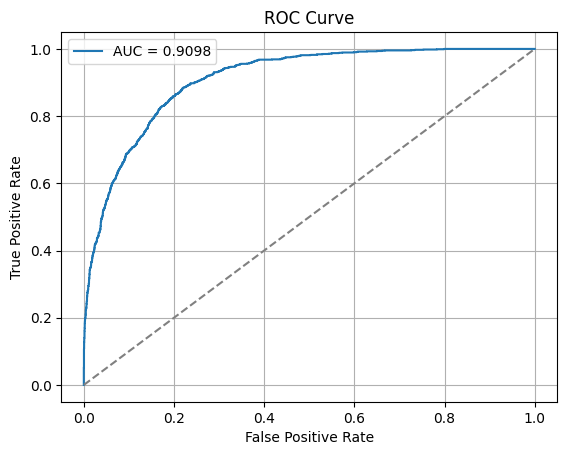

In [29]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int64)

test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=256)

X_final = np.vstack([X_train, X_dev]).astype(np.float32)
y_final = np.hstack([y_train, y_dev]).astype(np.int64)

final_dataset = TensorDataset(torch.tensor(X_final), torch.tensor(y_final))
final_loader = DataLoader(final_dataset, batch_size=64, shuffle=True)

model = ANN2(X_final.shape[1], 112, 32, 0.2009)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0058)
criterion = nn.BCELoss()

for epoch in range(20):
    model.train()
    for xb, yb in final_loader:
        xb = xb.float()
        yb = yb.float()
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

model.eval()
all_preds = []
all_probs = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.float()
        yb = yb.int()
        probs = model(xb)
        preds = (probs > 0.5).int()

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)
cm = confusion_matrix(all_targets, all_preds)

print("Confusion Matrix:\n", cm)
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC AUC Score : {auc:.4f}")

fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
j_scores = tpr - fpr
best_idx = j_scores.argmax()
thresholds = _
best_threshold = thresholds[best_idx]
auc_score = roc_auc_score(all_targets, all_probs)

In [32]:
best_threshold

0.24785022